# 1. Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Loading datasets
customers = pd.read_csv('data/olist_customers_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
products = pd.read_csv('data/olist_products_dataset.csv')
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
product_category_translation = pd.read_csv('data/product_category_name_translation.csv')

print(f"Customers: {customers.shape}")
print(f"Orders: {orders.shape}")
print(f"Order Items: {order_items.shape}")
print(f"Order Payments: {order_payments.shape}")
print(f"Products: {products.shape}")
print(f"Sellers: {sellers.shape}")
print(f"Geolocation: {geolocation.shape}")
print(f"Product Category Translation: {product_category_translation.shape}")
print("-------------------------\nAll datasets loaded successfully!")

Customers: (99441, 5)
Orders: (99441, 8)
Order Items: (112650, 7)
Order Payments: (103886, 5)
Products: (32951, 9)
Sellers: (3095, 4)
Geolocation: (1000163, 5)
Product Category Translation: (71, 2)
-------------------------
All datasets loaded successfully!


----
# 2. Data Cleaning and Preprocessing

### 2.1 Converting date columns to datetime

In [3]:
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                'order_delivered_customer_date', 'order_estimated_delivery_date']

orders[date_columns] = orders[date_columns].apply(pd.to_datetime, errors='coerce')

### 2.2 Merging dataset to create a comprehensive transaction data

In [4]:
merged_data = (orders
               .merge(customers, on='customer_id', how='inner')
               .merge(order_items, on='order_id', how='inner')
               .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
               .merge(product_category_translation, on='product_category_name', how='left')
              )

merged_data.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english'],
      dtype='object')

### 2.3 Calculating total price per order item (including freight)

In [6]:
merged_data['total_price'] = merged_data['price'] + merged_data['freight_value']

### 2.4 Removing orders with missing purchase timestamps or negative prices

In [7]:
merged_data = merged_data[
    (merged_data['order_purchase_timestamp'].notna()) &
    (merged_data['price'] > 0) &
    (merged_data['total_price'] > 0)
    ]

### 2.5 Filtering for completed orders (delivered to customer)

In [8]:
merged_data = merged_data[merged_data['order_status'] == 'delivered']

### 2.6 Creating a clean transaction dataset with essential columns

In [9]:
transaction_data = (
    merged_data[[
    'customer_id',
    'order_id',
    'order_purchase_timestamp',
    'total_price'
]]
    .copy()
    .sort_values('order_purchase_timestamp')
    .reset_index(drop=True)
)

### Getting basic insights of the final data after cleaning

In [10]:
print(f"Clean transaction data shape: {transaction_data.shape}")
print(f"Date range: {transaction_data['order_purchase_timestamp'].min()} to {transaction_data['order_purchase_timestamp'].max()}")
print(f"Total customers: {transaction_data['customer_id'].nunique()}")
print(f"Total transactions: {len(transaction_data)}")

Clean transaction data shape: (110197, 4)
Date range: 2016-09-15 12:16:38 to 2018-08-29 15:00:37
Total customers: 96478
Total transactions: 110197


----
# 3. Exploratory Data Analysis (EDA)

### 3.1 Visializing the data through different plots

In [11]:
transaction_data['total_price'].min(), transaction_data['total_price'].max(), transaction_data['total_price'].median()

(6.08, 6929.31, 92.13)

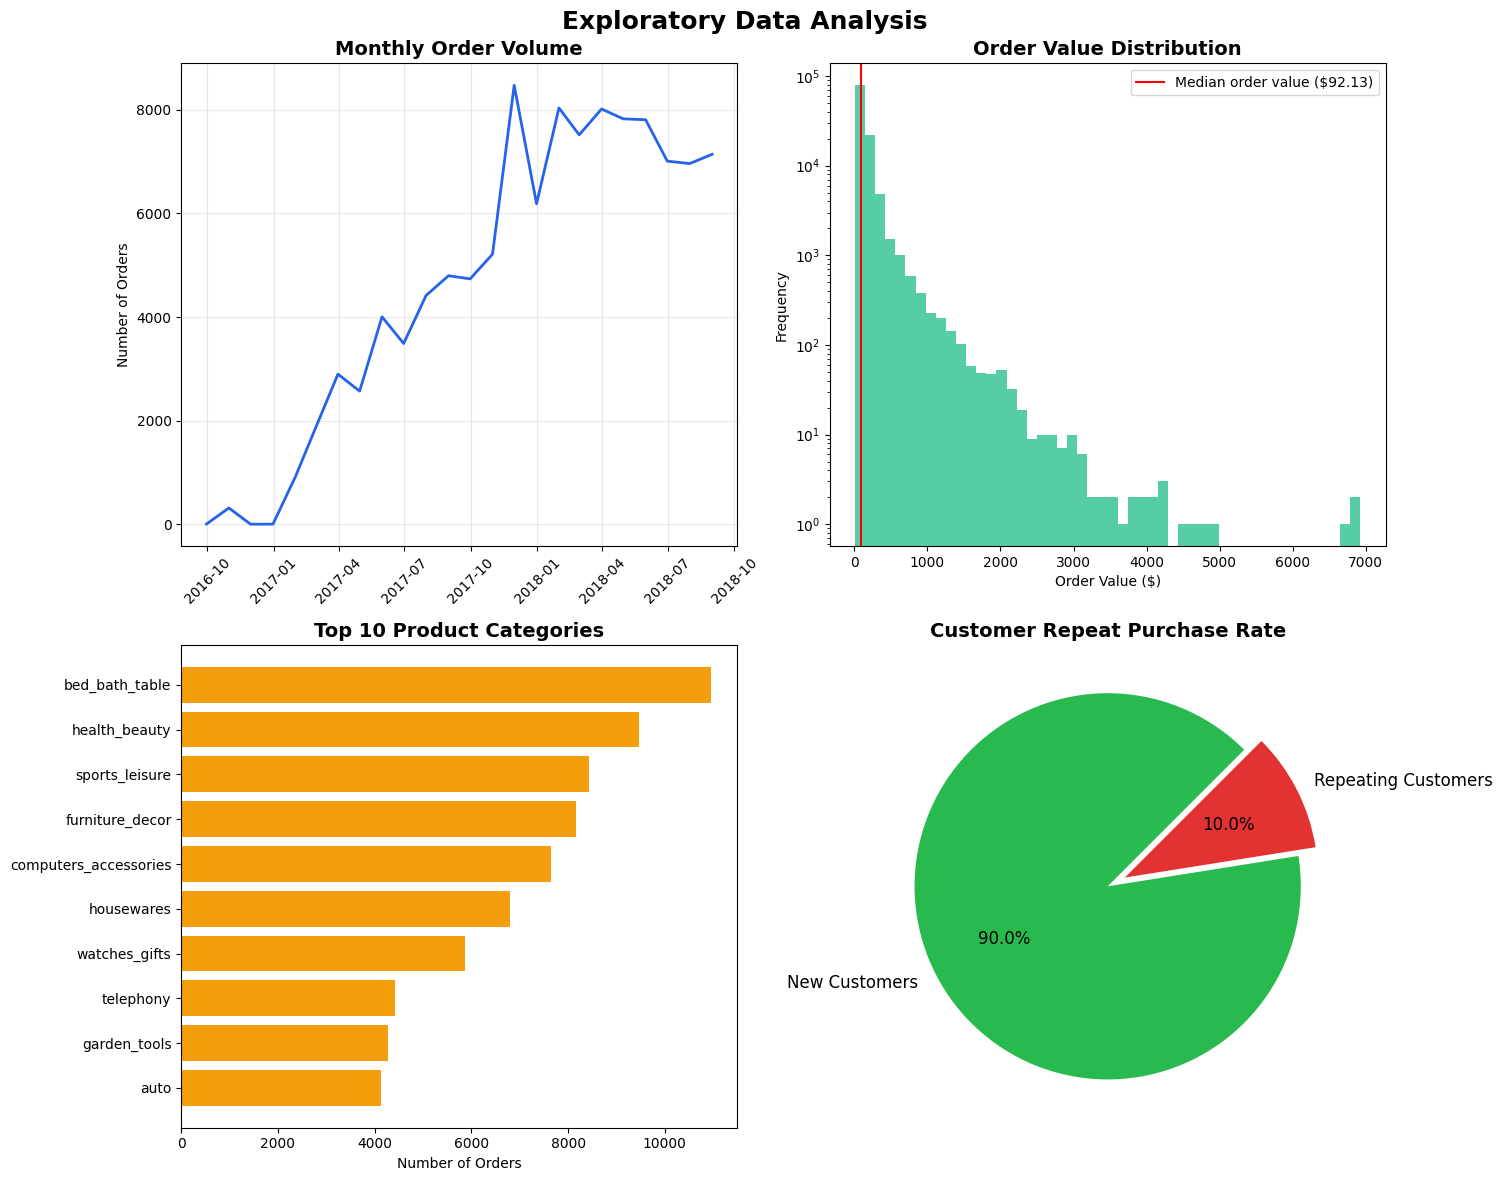

In [12]:
# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

font_size = 14
font_weight = 'bold'

# 1. Monthly order volume
monthly_orders = transaction_data.set_index('order_purchase_timestamp').resample('ME').size()
axes[0, 0].plot(monthly_orders.index, monthly_orders.values, linewidth=2, color='#2563eb')
axes[0, 0].set_title('Monthly Order Volume', fontsize=font_size, fontweight=font_weight)
axes[0, 0].set_ylabel('Number of Orders')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Order value distribution
axes[0, 1].hist(transaction_data['total_price'], bins=50, color='#10b981', alpha=0.7)
axes[0, 1].set_title('Order Value Distribution', fontsize=font_size, fontweight=font_weight)
axes[0, 1].set_xlabel('Order Value ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].axvline(transaction_data['total_price'].median(), color='red', label=f'Median order value (${transaction_data['total_price'].median()})')
axes[0, 1].legend()

# 3. Top product categories
top_categories = merged_data['product_category_name_english'].value_counts().head(10).sort_values()
axes[1, 0].barh(range(len(top_categories)), top_categories.values, color='#f59e0b')
axes[1, 0].set_yticks(range(len(top_categories)))
axes[1, 0].set_yticklabels(top_categories.index, fontsize=10)
axes[1, 0].set_title('Top 10 Product Categories', fontsize=font_size, fontweight=font_weight)
axes[1, 0].set_xlabel('Number of Orders')

# 4. Customer repeat purchase rate
customer_orders = transaction_data.groupby('customer_id').size()
repeat_customers = (customer_orders > 1).sum()
new_customers = (customer_orders == 1).sum()
axes[1, 1].pie([new_customers, repeat_customers], labels=['New Customers', 'Repeating Customers'], 
               autopct='%1.1f%%', colors=['#29BA4F', '#E33232'], textprops={"fontsize": 12}, explode=[0.0, 0.1], startangle=45)
axes[1, 1].set_title('Customer Repeat Purchase Rate', fontsize=font_size, fontweight=font_weight)

plt.suptitle('Exploratory Data Analysis', fontweight=font_weight, fontsize=18)
plt.tight_layout()
plt.show()

### 3.2 Summary statistics of the data

In [13]:
print("=== EDA Summary ===")
print(f"Average order value: ${transaction_data['total_price'].mean():.2f}")
print(f"Median order value: ${transaction_data['total_price'].median():.2f}")
print(f"Repeat customer rate: {repeat_customers / (new_customers + repeat_customers) * 100:.1f}%")
print(f"Total revenue: ${transaction_data['total_price'].sum():,.2f}")

=== EDA Summary ===
Average order value: $139.93
Median order value: $92.13
Repeat customer rate: 10.0%
Total revenue: $15,419,773.75


----
# 4. RFM Engineering

### 4.1 Defining the snapshot date

In [14]:
snapshot_date = transaction_data['order_purchase_timestamp'].max() + timedelta(days=1)
snapshot_date

Timestamp('2018-08-30 15:00:37')

### 4.2 Calculating RFM metrics

In [15]:
# Function for calculaing recent purchase tenure
def days_since_last_purchase(date):
    last_purchase = date.max()
    days_diff = (snapshot_date - last_purchase).days
    return days_diff

# RFM calculation
rfm = transaction_data.groupby('customer_id').agg({
    'order_purchase_timestamp': days_since_last_purchase,    # recency: days since last purchase
    'order_id': 'count',                                     # frequency: total number of orders
    'total_price': 'mean'                                    # monetary: average order value
})

# Renaming columns
rfm = rfm.rename(columns={
    'order_purchase_timestamp': 'recency',
    'order_id': 'frequency',
    'total_price': 'monetary_value'
})

### 4.3 Filtering customers with repeated purchases

In [16]:
rfm_filtered = rfm[rfm['frequency'] > 1].copy()

### 4.4 Calculating customer tenure (customer lifecycle since their first purchase)

In [17]:
first_purchase = transaction_data.groupby('customer_id')['order_purchase_timestamp'].min()

In [18]:
rfm_filtered['T'] = (snapshot_date - first_purchase[rfm_filtered.index]).dt.days
rfm_filtered['customer_tenure'] = rfm_filtered['T']

### 4.5 Summary

In [19]:
print('------------- RFM features created -------------')
print(f'Total customers with RFM data: {len(rfm)}')
print(f'Customers with repeating (>1) purchases: {len(rfm_filtered)}')
print()
print('------------- RFM Summary Statistics -------------')
print(rfm_filtered.describe())

------------- RFM features created -------------
Total customers with RFM data: 96478
Customers with repeating (>1) purchases: 9635

------------- RFM Summary Statistics -------------
           recency    frequency  monetary_value            T  customer_tenure
count  9635.000000  9635.000000     9635.000000  9635.000000      9635.000000
mean    240.967826     2.423871      103.497587   240.967826       240.967826
std     151.419306     1.040238      106.492581   151.419306       151.419306
min       1.000000     2.000000        9.341429     1.000000         1.000000
25%     118.000000     2.000000       49.410000   118.000000       118.000000
50%     222.000000     2.000000       75.960000   222.000000       222.000000
75%     346.000000     2.000000      121.440000   346.000000       346.000000
max     714.000000    21.000000     2222.750000   714.000000       714.000000


----
# 5. Visualizing RFM distribution

### 5.1 Recency, Frequency and Monetary Value Distribution

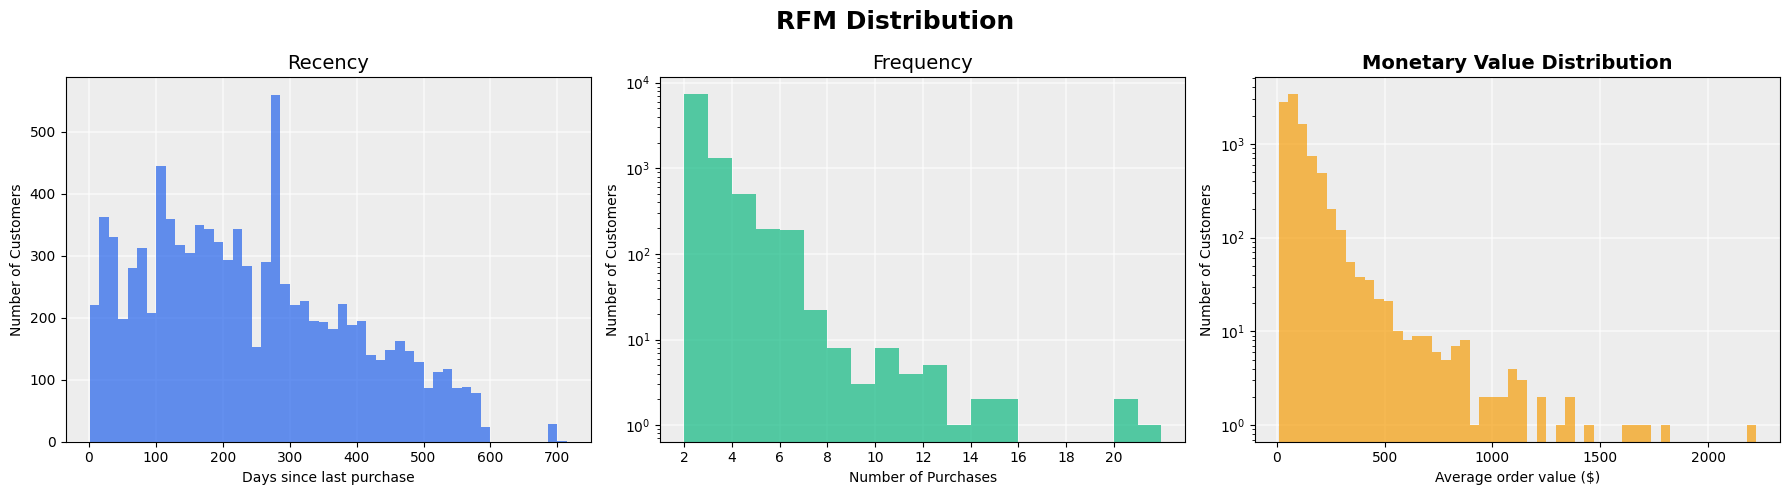

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

size = 14
grid_kwargs = dict(color='white', linestyle='-', linewidth=1.5, alpha=0.5)
    
# Recency distribution
axes[0].hist(rfm_filtered['recency'], bins=50, color='#2563EB', alpha=0.7)
axes[0].set_title('Recency', fontsize=size)
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Number of Customers')

# Frequency Distribution
freq = rfm_filtered['frequency']
bins = np.arange(freq.min(), freq.max() + 2)
axes[1].hist(freq, bins=bins, color='#10B981', alpha=0.7)
axes[1].set_xticks(np.arange(freq.min(), freq.max() + 1, 2))
axes[1].set_title('Frequency', fontsize=size)
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Customers')
axes[1].set_yscale('log')


#M Monetary value distribution
axes[2].hist(rfm_filtered['monetary_value'], bins=50, color='#f59e0b', alpha=0.7)
axes[2].set_title('Monetary Value Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Average order value ($)')
axes[2].set_ylabel('Number of Customers')
axes[2].set_yscale('log')

for axis in axes:
    axis.set_facecolor('#EDEDED')
    axis.grid(True, **grid_kwargs)
    axis.set_axisbelow(True)

plt.suptitle('RFM Distribution', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

### 5.2 RFM Correlation Matrix

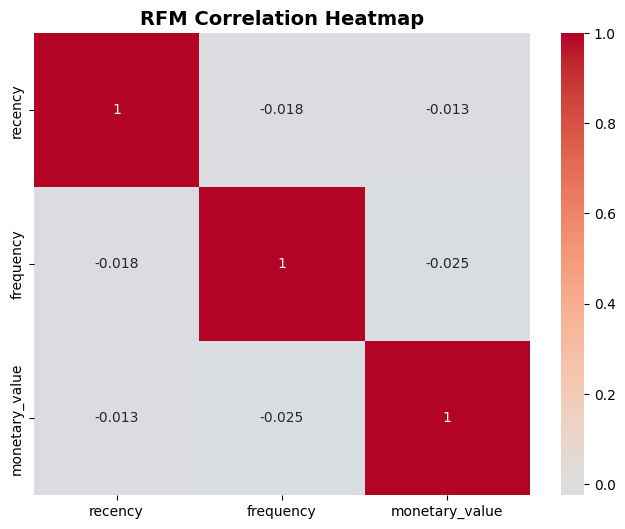

In [23]:
plt.figure(figsize=(8,6))
corr_matrix = rfm_filtered[[
    'recency',
    'frequency',
    'monetary_value'
]].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, center=0)
plt.title('RFM Correlation Heatmap', fontsize=14, fontweight='bold')
plt.show()

----
# 6. Customer Lifetme Value (CLV) Modelling

In [24]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

### 6.1 Preparing input data for the models

In [25]:
# BG/NBD: requires frequency, recency, and customer tenure
bg_nbd_data = rfm_filtered[['frequency', 'recency', 'customer_tenure']].copy()

# Gamma-gamma needs frequency and monetary value
monetary_data = rfm_filtered[['frequency', 'monetary_value']].copy()

### 6.2 Fitting the BG/NBD Model (purchase frequency model)

In [26]:
print('Fitting BG/NBD Model...')

bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(
    frequency=bg_nbd_data['frequency'],
    recency=bg_nbd_data['recency'],
    T=bg_nbd_data['customer_tenure']
)

Fitting BG/NBD Model...


<lifetimes.BetaGeoFitter: fitted with 9635 subjects, a: 0.00, alpha: 157.69, b: 0.00, r: 2.08>

### 6.3 Fitting the Gamma-Gamma Model (monetary value model)

In [27]:
print('Fitting Gamma-Gamma Model...')

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(
    frequency=monetary_data['frequency'],
    monetary_value=monetary_data['monetary_value']
)

Fitting Gamma-Gamma Model...


<lifetimes.GammaGammaFitter: fitted with 9635 subjects, p: 4.15, q: 0.59, v: 4.00>

### 6.4 Predicting 12-month customer lifetime value (CLV)

In [30]:
print('Predicting 12-month CLV...')
clv_12m = ggf.customer_lifetime_value(
    transaction_prediction_model=bgf,
    frequency=bg_nbd_data['frequency'],
    recency=bg_nbd_data['recency'],
    T=bg_nbd_data['customer_tenure'],
    monetary_value=monetary_data['monetary_value'],
    time=12,
    discount_rate=0.01,
)
print('Predicted data generated\n')

# Adding the predicted values' column to a new dataframe
rfm_results = rfm_filtered.copy()
rfm_results['clv_bg_nbd'] = clv_12m.values

Predicting 12-month CLV...
Predicted data generated



### 6.5 CLV Summary

In [31]:
print('------------- BG/NBD + Gamma-Gamma CLV Summary -------------')
print(f'Average predicted CLV (12 months): ${rfm_results['clv_bg_nbd'].mean():.2f}')
print(f'Median predicted CLV (12 months): ${rfm_results['clv_bg_nbd'].median():.2f}')

------------- BG/NBD + Gamma-Gamma CLV Summary -------------
Average predicted CLV (12 months): $489.62
Median predicted CLV (12 months): $330.42


----
# 7. ML Modelling for CLV Prediction (using Random Forest)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 7.1 Preparing features for modelling

In [33]:
ml_features = rfm_filtered.copy()
ml_features['clv_bg_nbd'] = clv_12m
ml_features['purchase_rate'] = ml_features['frequency'] / ml_features['customer_tenure']
ml_features['avg_days_between_purchases'] = ml_features['recency'] / (ml_features['frequency']-1)

### 7.2 Handling infinite values in average days between purchases

In [34]:
ml_features['avg_days_between_purchases'].replace([np.inf, -np.inf], np.nan, inplace=True)
ml_features['avg_days_between_purchases'].fillna(ml_features['customer_tenure'], inplace=True)

### 7.3 Selecting features and target

In [35]:
feature_columns = ['recency', 'frequency', 'monetary_value', 'customer_tenure', 'purchase_rate', 'avg_days_between_purchases']

X = ml_features[feature_columns]
y = ml_features['clv_bg_nbd']

### 7.4 Splitting data into train and test sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7.5 Scaling features

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 7.6 Training Random Forest and making predictions

In [38]:
print('Training Random Forest model...')
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

Training Random Forest model...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 7.7 Making predictions

In [39]:
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

### 7.8 Evaluating the model

In [41]:
# For training data
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# For testing data
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print('------------- Random Forest model performance -------------')
print(f'Train MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}')
print(f'Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}')
print(f'Train R\u00B2: {train_r2:.3f} | Test R\u00B2: {train_r2:.3f}')

# Adding predictions back to the results
ml_features['clv_rf'] = rf_model.predict(scaler.transform(ml_features[feature_columns]))
rfm_results['clv_rf'] = ml_features['clv_rf']

------------- Random Forest model performance -------------
Train MSE: 2232.89 | Test MSE: 2699.54
Train MAE: 4.81 | Test MAE: 10.16
Train R²: 0.994 | Test R²: 0.994


----
# 8. Model Comparison and Validation

### 8.1 Creating comparison dataframe

In [42]:
comparison_df = rfm_results[['clv_bg_nbd', 'clv_rf']].copy()
comparison_df['clv_difference'] = comparison_df['clv_bg_nbd'] - comparison_df['clv_rf']

### 8.2 Calculating correlation between models

In [43]:
correlation = comparison_df['clv_bg_nbd'].corr(comparison_df['clv_rf'])

### 8.3 Model comparison summary

In [44]:
print('------------- Model Comparison Summary -------------')
print(f'Correlation between models: {correlation:.3f}')
print()
print(f'BG/NBD:\n       Mean CLV: {comparison_df['clv_bg_nbd'].mean():.2f}\n       Median CLV: {comparison_df['clv_bg_nbd'].median():.2f}')
print(f'Random Forest:\n       Mean CLV: {comparison_df['clv_rf'].mean():.2f}\n       Median CLV: {comparison_df['clv_rf'].median():.2f}')

------------- Model Comparison Summary -------------
Correlation between models: 0.997

BG/NBD:
       Mean CLV: 489.62
       Median CLV: 330.42
Random Forest:
       Mean CLV: 488.64
       Median CLV: 330.83


### 8.4 Model comparison visualization